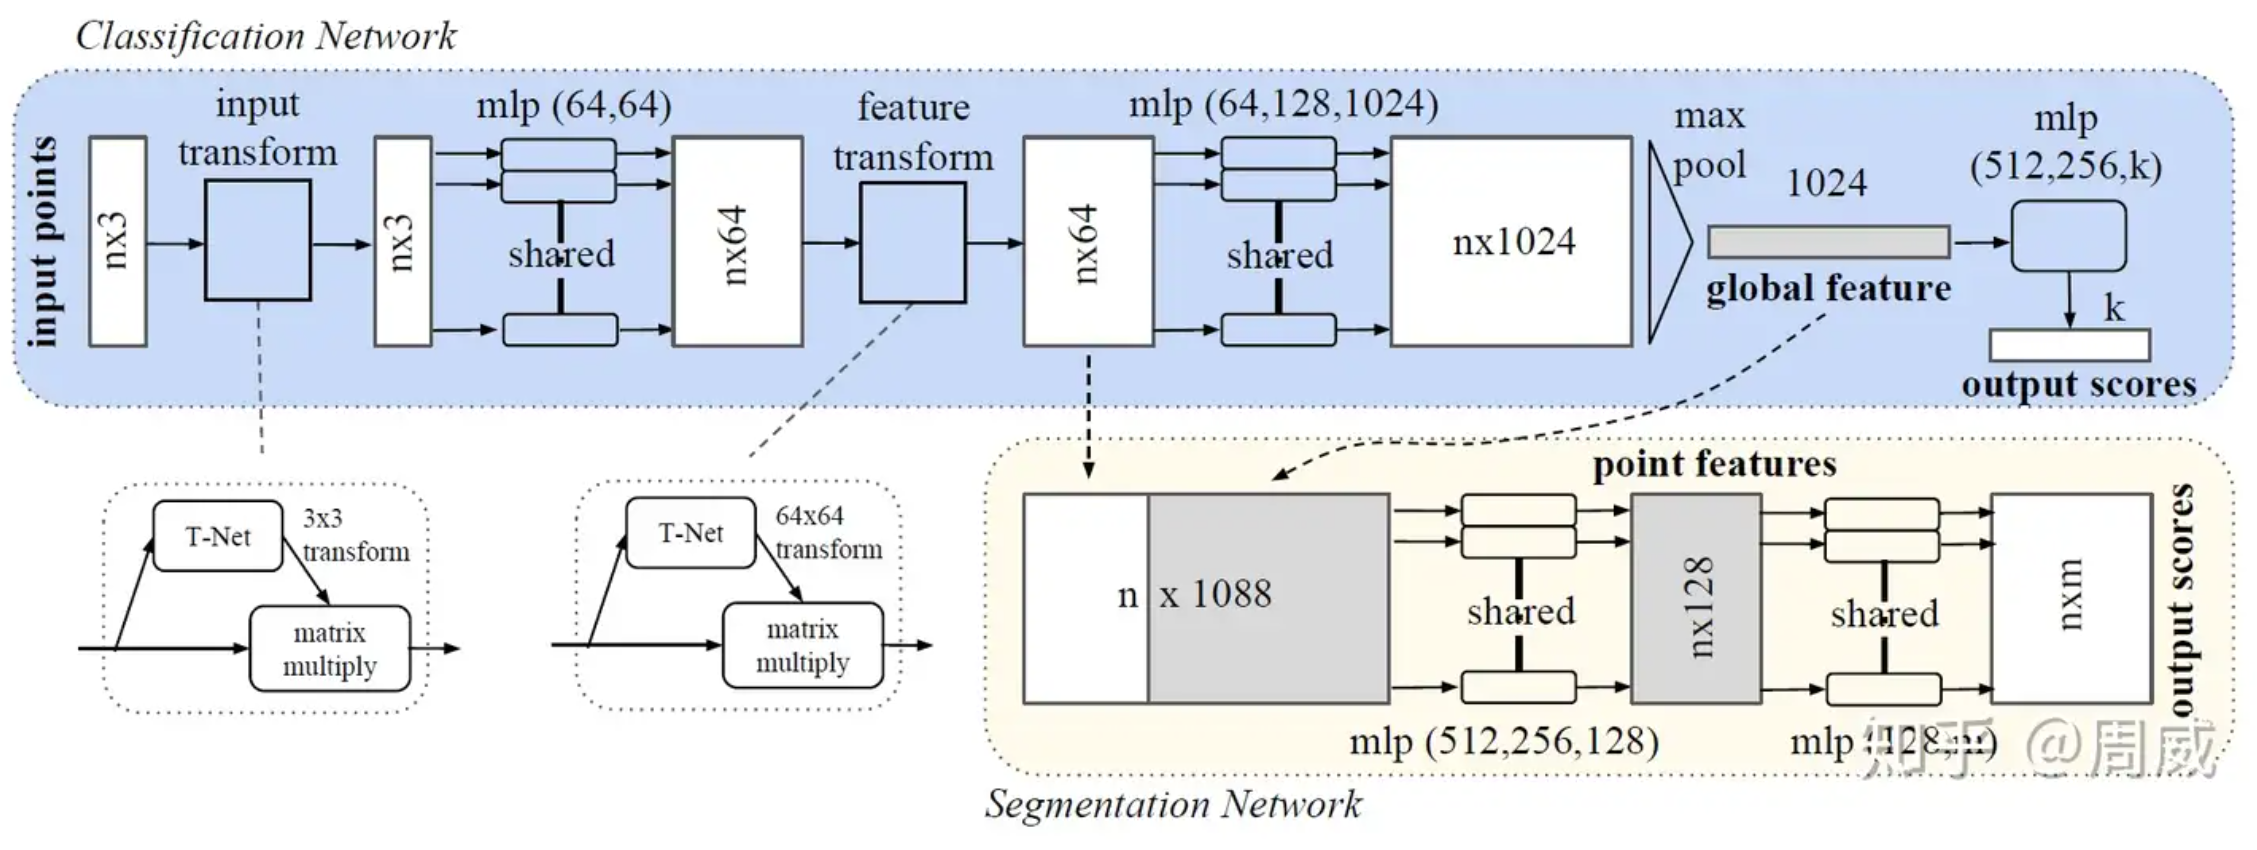

1.输入为一帧的全部点云数据的集合，表示为一个nx3的2d tensor，其中n为点云数量，3为xyz坐标      
2.输入数据县通过一个T-Net**学习到的转换矩阵**相乘来对齐，保证了模型的对特定**空间转换的不变性**     
3.通过多次mlp对各点云数据进行**特征提取后**，再用一个T-Net对特征进行**对齐**     
4.在特征的各个维度上执行**maxpooling**操作得到最终的**全局特征**

https://github.com/yanx27/Pointnet_Pointnet2_pytorch

In [5]:
import torch
import torch.nn as nn
import numpy as np

In [6]:
class STN3d(nn.Module):
    def __init__(self, channel):
        super(STN3d, self).__init__()
        self.conv1 = torch.nn.Conv1d(channel, 64, 1)
        self.conv2 = torch.nn.Conv1d(64, 128, 1)
        self.conv3 = torch.nn.Conv1d(128, 1024, 1)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 9)
        self.relu = nn.ReLU()

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)

    def forward(self, x):
        batchsize = x.size()[0] # shape (batch_size,3,point_nums)
        x = F.relu(self.bn1(self.conv1(x))) # shape (batch_size,64,point_nums)
        x = F.relu(self.bn2(self.conv2(x))) # shape (batch_size,128,point_nums)
        x = F.relu(self.bn3(self.conv3(x))) # shape (batch_size,1024,point_nums)
        x = torch.max(x, 2, keepdim=True)[0] # shape (batch_size,1024,1)
        x = x.view(-1, 1024) # shape (batch_size,1024)

        x = F.relu(self.bn4(self.fc1(x))) # shape (batch_size,512)
        x = F.relu(self.bn5(self.fc2(x))) # shape (batch_size,256)
        x = self.fc3(x) # shape (batch_size,9)

        iden = Variable(torch.from_numpy(np.array([1, 0, 0, 0, 1, 0, 0, 0, 1]).astype(np.float32))).view(1, 9).repeat(
            batchsize, 1) # # shape (batch_size,9)
        if x.is_cuda:
            iden = iden.cuda()
        # that's the same thing as adding a diagonal matrix(full 1)
        x = x + iden # iden means that add the input-self
        x = x.view(-1, 3, 3) # shape (batch_size,3,3)
        return x

**疑问：transform中直接连过去的iden是什么，有什么作用，是和残差类似吗？**

**pointnet++**

pointnet的一个缺陷就是**没有提取局部特征**，导致**模型泛化能力有限**

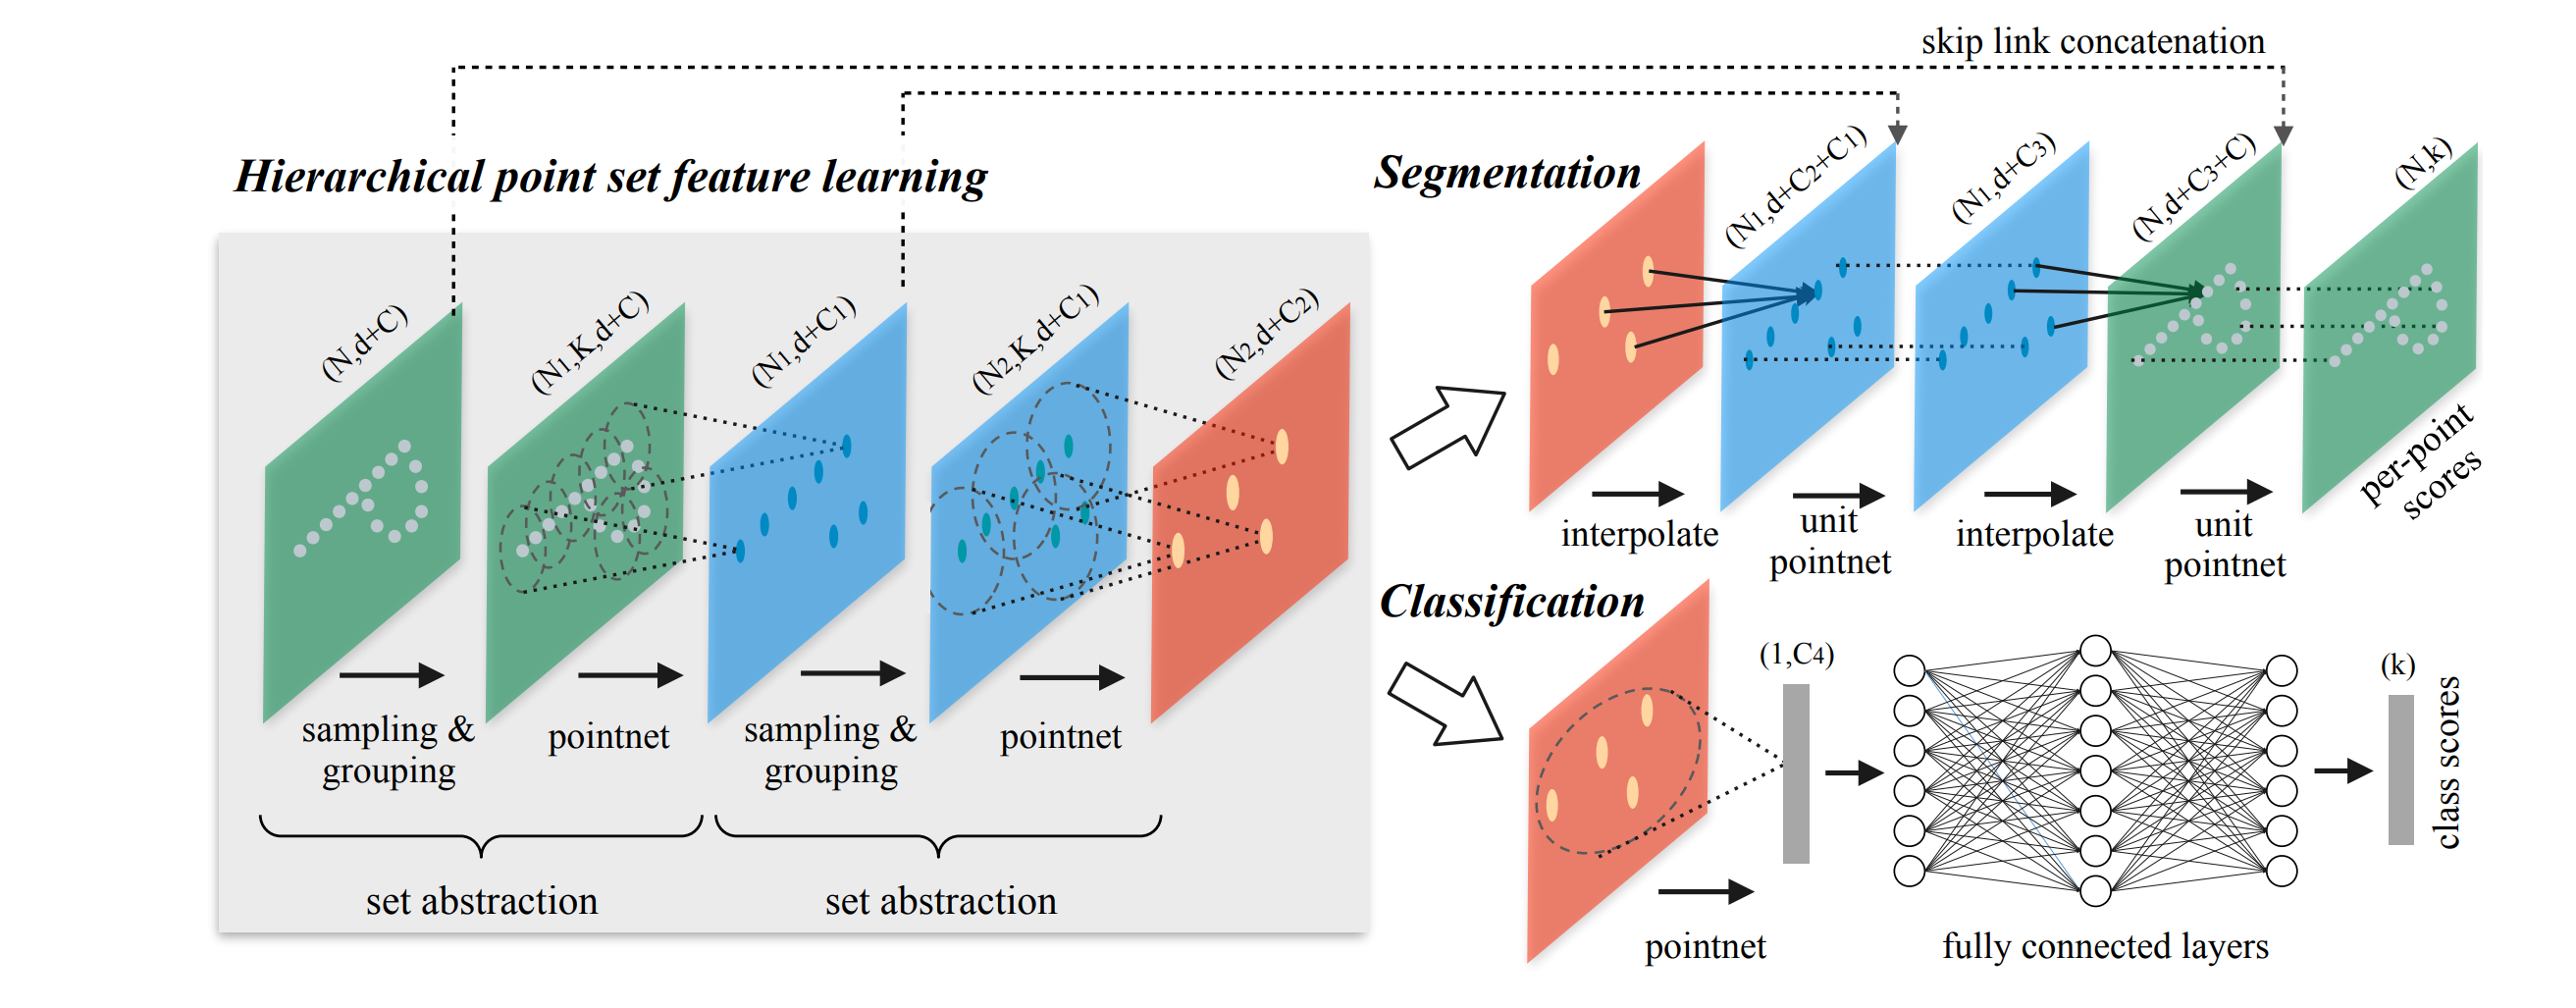

**问题1：点云往往有非常多的点，这会造成计算量过大而限制模型使用**      
在所有点云数据中(假设有N个点)**采样**N'个点，同时希望N'个点能够包含尽可能多的有用信息。farthest point sampling algorithm,**FPS最远点采样**

1.**随机选择一个点**作为初始点作为**已采样点**       
2.计算**未采样点集**中每个点与**已采样点**之间的**距离**，将距离最大的那个点加入已选择采样点集       
3.更新距离，一直迭代辖区，直至获得了**目标数量**的采样点

In [8]:
def farthest_point_sample(xyz, npoint):
    """
    Input:
        xyz: pointcloud data, [B, N, 3]
        npoint: number of samples
    Return:
        centroids: sampled pointcloud index, [B, npoint]
    """
    device = xyz.device
    B, N, C = xyz.shape
    centroids = torch.zeros(B, npoint, dtype=torch.long).to(device)
    distance = torch.ones(B, N).to(device) * 1e10
    farthest = torch.randint(0, N, (B,), dtype=torch.long).to(device)
    batch_indices = torch.arange(B, dtype=torch.long).to(device)
    for i in range(npoint):
        centroids[:, i] = farthest
        centroid = xyz[batch_indices, farthest, :].view(B, 1, 3)
        dist = torch.sum((xyz - centroid) ** 2, -1)
        mask = dist < distance
        distance[mask] = dist[mask]
        farthest = torch.max(distance, -1)[1]
    return centroids

**为什么这里返回的是[B, npoint]而不是[B, npoint, 3]，为什么第三个维度没有了**

**问题2：如何将点集划分为不同的区域，并获取不同区域的局部特征？**         
**ball query**group策略**区域特征提取器**：            
1.**预设**搜索区域的**半径**R与子区域的**点数**K       
2.上面提取出来的N'个点，作为N'个centriods，以这N'个点作为球心，划分半径为R的球体             
3.在每个以centridos的球心的球体内搜索距离centriods最近的k个点。如果query ball的点数量对于规模K，那么直接取最近的k个作为子区域，如果不足，那么对这个点重新采样，凑够k       
4.获取N'个centriods对应的N'个子区域，每个子区域k个点。这里k个点就接近cnn中卷积核kxk区域的感觉      

对于问题1就是**sampling layer**,输入的是N x (d + c),N为点云数据点的数量，d为xyz坐标，c是点上的特征(用来形容点的属性，一般为0)，那么通过sampling layer后，N' x (d + c)      
对于问题2就是**grouping layer**，输出是N' x K x (d + C)

接下来对每个子区域使用**pointnet**来进行区域特征提取       
**sample layer + grounping layer + pointnet = set abstraction**

In [10]:
class PointNetSetAbstraction(nn.Module):
    def __init__(self, npoint, radius, nsample, in_channel, mlp, group_all):
        super(PointNetSetAbstraction, self).__init__()
        self.npoint = npoint
        self.radius = radius
        self.nsample = nsample
        self.mlp_convs = nn.ModuleList()
        self.mlp_bns = nn.ModuleList()
        last_channel = in_channel
        for out_channel in mlp:
            self.mlp_convs.append(nn.Conv2d(last_channel, out_channel, 1))
            self.mlp_bns.append(nn.BatchNorm2d(out_channel))
            last_channel = out_channel
        self.group_all = group_all

    def forward(self, xyz, points):
        """
        Input:
            xyz: input points position data, [B, C, N]
            points: input points data, [B, D, N]
        Return:
            new_xyz: sampled points position data, [B, C, S]
            new_points_concat: sample points feature data, [B, D', S]
        """
        xyz = xyz.permute(0, 2, 1)
        if points is not None:
            points = points.permute(0, 2, 1)

        if self.group_all:
            new_xyz, new_points = sample_and_group_all(xyz, points)
        else:
            new_xyz, new_points = sample_and_group(self.npoint, self.radius, self.nsample, xyz, points)
        # new_xyz: sampled points position data, [B, npoint, C]
        # new_points: sampled points data, [B, npoint, nsample, C+D]
        new_points = new_points.permute(0, 3, 2, 1) # [B, C+D, nsample,npoint]
        for i, conv in enumerate(self.mlp_convs):
            bn = self.mlp_bns[i]
            new_points =  F.relu(bn(conv(new_points)))

        new_points = torch.max(new_points, 2)[0]
        new_xyz = new_xyz.permute(0, 2, 1)
        return new_xyz, new_points

**这里输出的维度分别是多少**

问题3：点云**不均匀**的时候，在密集区域学习出来的特征可能不应用与稀疏区域

**Multi-scale grouping(MSG)**       
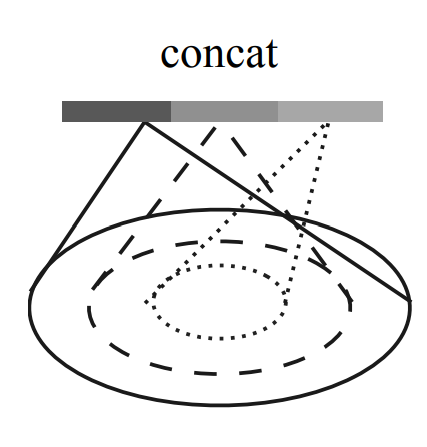

**Multi-resolution grouping(MRG)**        
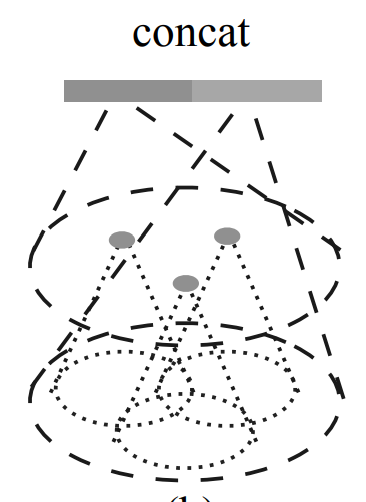

MSG的计算量大于MRG，所以采用MRG

问题4：连续的set abstraction层对原始点进行下采样而获得数量更少的特征点，如何从这些特征点中实现原始点云数据的分割任务？        
**基于距离插值**的分层特征传播

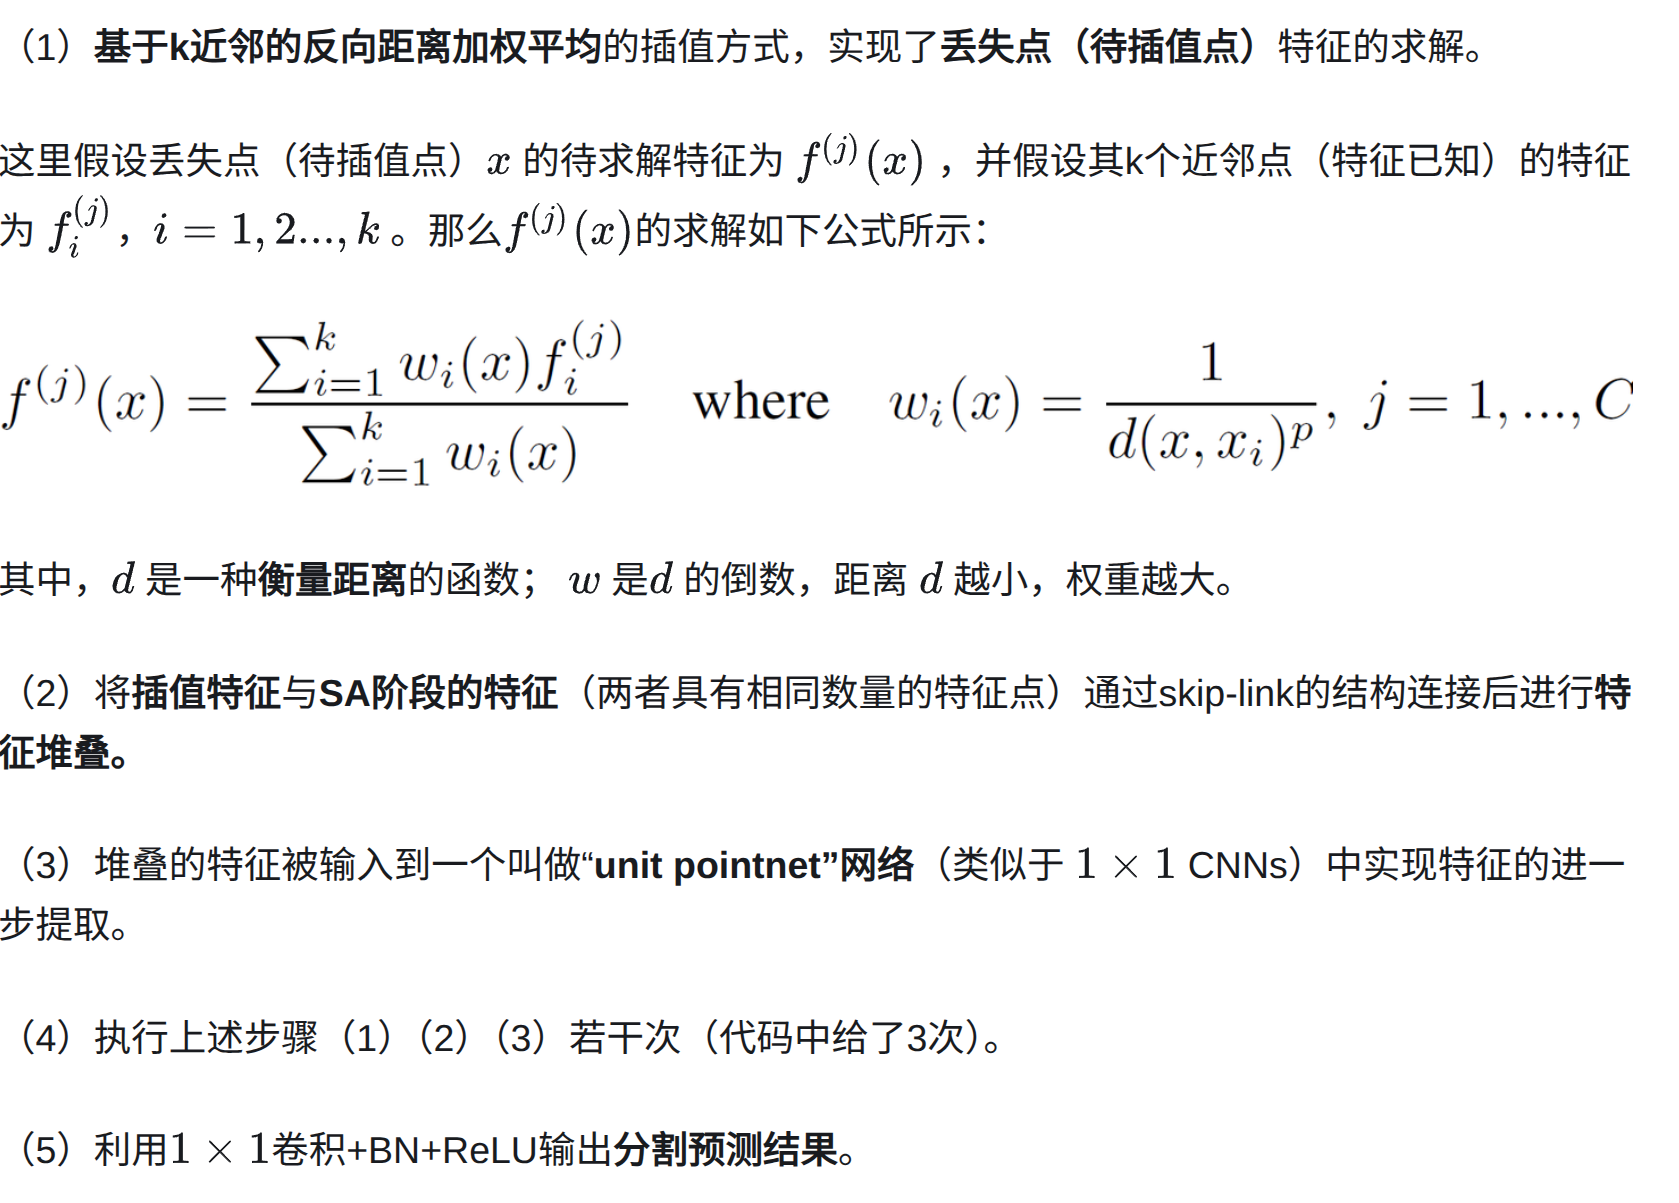